[View in Colaboratory](https://colab.research.google.com/github/yylonly/GoogleCoLab/blob/master/4_ServeNet_LTSM_(Glove200b_trainedEmbeddingLayer).ipynb)

## ServeNet-LTSM (Glove50b-trainedEmbeddingLayer)

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("/content/drive/Colab Notebooks/")

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [43]:
!ls -l

total 88668
drwxr-xr-x 2 root root     4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root     4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root     4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root     4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root     4096 Mar  1 18:00 17.Face Recognition
drwxr-xr-x 2 root root     4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root     4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root   395741 May  5 09:24 4.ServeNet-LTSM (Glove100b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root   564560 May  5 12:51 4.ServeNet-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root    48080 Mar 29 16:22 CalligraphyColorNet.ipynb
-rw-r--r-- 1 root root  1377049 Mar 19 08:13 CalligraphyNet.ipynb
-rw-r--r-- 1 root root   969393 Mar 31 08:46 Copy of CalligraphyColorNet (019b6ded).ipynb
-rw-r--r-- 1 root root   969393 Apr  3 08:48 Copy of CalligraphyColor

In [7]:
# To support current plaidml using Keras 2.0.8
import keras; print(keras.__version__)
!pip install keras==2.0.8
import keras; print(keras.__version__)

2.1.6
    100% |████████████████████████████████| 276kB 4.4MB/s 
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
      Successfully uninstalled Keras-2.1.6
2.1.6


In [0]:
#import plaidml.keras
#plaidml.keras.install_backend()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import h5py
import pandas as pd

#from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras import metrics
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint

np.random.seed(0)
%matplotlib inline

In [64]:
h5f = h5py.File('data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:]
Y_train = h5f['Train_Y_one_hot'][:]
X_test = h5f['indexed_padded_Test_X'][:]
Y_test = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8123, 110) (8123, 50)
(2061, 110) (2061, 50)


In [10]:
X_train[0]

array([192973,  54273, 270501, 294803, 286278, 121851, 360915, 363921,
       270193, 219115, 154323, 278439, 291761, 191811, 191143, 270193,
       133719, 142813, 388756, 306178, 104329, 142808, 374253, 357266,
       286278, 354433,  54718, 345909, 236860, 142838,  90548, 327482,
       357354, 209662, 374253,  43010, 111455,  91182, 156214,  58791,
       270501,  57488,  54718, 149979, 136170, 270927, 294049,  43010,
       332120, 186717,  69725,  57459, 151349,  86371, 191143, 219115,
        57840, 386474,  58997,  89857, 156216, 122453, 374163, 182908,
       199199, 113067, 360915, 111448, 156216, 386474,  58997, 357412,
       182158, 269798, 357266, 286278,  54718, 107110,  88126, 354433,
       151349, 219113, 360915, 191135, 388711, 357266, 325899, 268046,
       325776, 188836, 281890,  61645, 373469, 363840,  54718,  61640,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0], dtype=int32)

In [11]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.200d.txt')

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
# GRADED FUNCTION: Emojify_V2

def ServeNet(input_shape):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trainable_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(256, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(256, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(50)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [0]:
maxLen = 110

In [18]:
model = ServeNet((maxLen, ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 110)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 110, 200)          80000200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 110, 256)          467968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12850     
__________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy, metrics.top_k_categorical_accuracy])

In [21]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 100, batch_size = 128)

Train on 8123 samples, validate on 2061 samples
Epoch 1/100
8123/8123 [==============================] - 37s 5ms/step - loss: 3.7676 - categorical_accuracy: 0.0676 - top_k_categorical_accuracy: 0.2527 - val_loss: 3.7208 - val_categorical_accuracy: 0.0728 - val_top_k_categorical_accuracy: 0.2635
Epoch 2/100
8123/8123 [==============================] - 36s 4ms/step - loss: 3.7331 - categorical_accuracy: 0.0714 - top_k_categorical_accuracy: 0.2639 - val_loss: 3.7125 - val_categorical_accuracy: 0.0728 - val_top_k_categorical_accuracy: 0.2673
Epoch 3/100
8123/8123 [==============================] - 36s 4ms/step - loss: 3.7258 - categorical_accuracy: 0.0723 - top_k_categorical_accuracy: 0.2649 - val_loss: 3.7161 - val_categorical_accuracy: 0.0776 - val_top_k_categorical_accuracy: 0.2678
Epoch 4/100
1664/8123 [=====>........................] - ETA: 26s - loss: 3.7208 - categorical_accuracy: 0.0757 - top_k_categorical_accuracy: 0.2578

8123/8123 [==============================] - 36s 4ms/step - loss: 3.6825 - categorical_accuracy: 0.0889 - top_k_categorical_accuracy: 0.2779 - val_loss: 3.6337 - val_categorical_accuracy: 0.1000 - val_top_k_categorical_accuracy: 0.2780
Epoch 5/100
8123/8123 [==============================] - 36s 4ms/step - loss: 3.6512 - categorical_accuracy: 0.0913 - top_k_categorical_accuracy: 0.2911 - val_loss: 3.5929 - val_categorical_accuracy: 0.1150 - val_top_k_categorical_accuracy: 0.3227
Epoch 6/100
8123/8123 [==============================] - 37s 5ms/step - loss: 3.6164 - categorical_accuracy: 0.1152 - top_k_categorical_accuracy: 0.3212 - val_loss: 3.6033 - val_categorical_accuracy: 0.1145 - val_top_k_categorical_accuracy: 0.3086
Epoch 7/100
3712/8123 [============>.................] - ETA: 18s - loss: 3.7483 - categorical_accuracy: 0.0711 - top_k_categorical_accuracy: 0.2540

8123/8123 [==============================] - 37s 5ms/step - loss: 3.7450 - categorical_accuracy: 0.0702 - top_k_categorical_accuracy: 0.2566 - val_loss: 3.7191 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2639
Epoch 8/100
8123/8123 [==============================] - 37s 5ms/step - loss: 3.7320 - categorical_accuracy: 0.0696 - top_k_categorical_accuracy: 0.2607 - val_loss: 3.7121 - val_categorical_accuracy: 0.0704 - val_top_k_categorical_accuracy: 0.2659
Epoch 9/100
8123/8123 [==============================] - 36s 4ms/step - loss: 3.7183 - categorical_accuracy: 0.0774 - top_k_categorical_accuracy: 0.2663 - val_loss: 3.7149 - val_categorical_accuracy: 0.0898 - val_top_k_categorical_accuracy: 0.2639
Epoch 10/100
4096/8123 [==============>...............] - ETA: 16s - loss: 3.7165 - categorical_accuracy: 0.0779 - top_k_categorical_accuracy: 0.2656

8123/8123 [==============================] - 35s 4ms/step - loss: 3.7171 - categorical_accuracy: 0.0821 - top_k_categorical_accuracy: 0.2626 - val_loss: 3.6662 - val_categorical_accuracy: 0.0762 - val_top_k_categorical_accuracy: 0.2926
Epoch 11/100
8123/8123 [==============================] - 36s 4ms/step - loss: 3.5211 - categorical_accuracy: 0.1262 - top_k_categorical_accuracy: 0.3404 - val_loss: 3.3787 - val_categorical_accuracy: 0.1354 - val_top_k_categorical_accuracy: 0.3692
Epoch 12/100
8123/8123 [==============================] - 36s 4ms/step - loss: 3.3802 - categorical_accuracy: 0.1280 - top_k_categorical_accuracy: 0.3830 - val_loss: 3.4267 - val_categorical_accuracy: 0.1092 - val_top_k_categorical_accuracy: 0.3639
Epoch 13/100
4096/8123 [==============>...............] - ETA: 16s - loss: 3.3126 - categorical_accuracy: 0.1365 - top_k_categorical_accuracy: 0.4033

8123/8123 [==============================] - 36s 4ms/step - loss: 3.2774 - categorical_accuracy: 0.1477 - top_k_categorical_accuracy: 0.4135 - val_loss: 3.1773 - val_categorical_accuracy: 0.1737 - val_top_k_categorical_accuracy: 0.4498
Epoch 14/100
8123/8123 [==============================] - 36s 4ms/step - loss: 3.1270 - categorical_accuracy: 0.1853 - top_k_categorical_accuracy: 0.4613 - val_loss: 3.0890 - val_categorical_accuracy: 0.1912 - val_top_k_categorical_accuracy: 0.4876
Epoch 15/100
8123/8123 [==============================] - 36s 4ms/step - loss: 3.0404 - categorical_accuracy: 0.1903 - top_k_categorical_accuracy: 0.4961 - val_loss: 2.9710 - val_categorical_accuracy: 0.2164 - val_top_k_categorical_accuracy: 0.5177
Epoch 16/100
4096/8123 [==============>...............] - ETA: 16s - loss: 2.8602 - categorical_accuracy: 0.2251 - top_k_categorical_accuracy: 0.5520

8123/8123 [==============================] - 36s 4ms/step - loss: 2.8691 - categorical_accuracy: 0.2252 - top_k_categorical_accuracy: 0.5487 - val_loss: 2.8464 - val_categorical_accuracy: 0.2319 - val_top_k_categorical_accuracy: 0.5662
Epoch 17/100
8123/8123 [==============================] - 36s 4ms/step - loss: 2.7775 - categorical_accuracy: 0.2425 - top_k_categorical_accuracy: 0.5782 - val_loss: 2.7595 - val_categorical_accuracy: 0.2416 - val_top_k_categorical_accuracy: 0.5798
Epoch 18/100
8123/8123 [==============================] - 36s 4ms/step - loss: 2.7014 - categorical_accuracy: 0.2582 - top_k_categorical_accuracy: 0.6014 - val_loss: 2.7385 - val_categorical_accuracy: 0.2707 - val_top_k_categorical_accuracy: 0.5900
Epoch 19/100
4096/8123 [==============>...............] - ETA: 16s - loss: 2.6433 - categorical_accuracy: 0.2715 - top_k_categorical_accuracy: 0.6094

8123/8123 [==============================] - 36s 4ms/step - loss: 2.6292 - categorical_accuracy: 0.2747 - top_k_categorical_accuracy: 0.6226 - val_loss: 2.6400 - val_categorical_accuracy: 0.2877 - val_top_k_categorical_accuracy: 0.6172
Epoch 20/100
8123/8123 [==============================] - 36s 4ms/step - loss: 2.6018 - categorical_accuracy: 0.2791 - top_k_categorical_accuracy: 0.6323 - val_loss: 2.6003 - val_categorical_accuracy: 0.2897 - val_top_k_categorical_accuracy: 0.6167
Epoch 21/100
8123/8123 [==============================] - 36s 4ms/step - loss: 2.4551 - categorical_accuracy: 0.3208 - top_k_categorical_accuracy: 0.6686 - val_loss: 2.4913 - val_categorical_accuracy: 0.3149 - val_top_k_categorical_accuracy: 0.6628
Epoch 22/100
4096/8123 [==============>...............] - ETA: 16s - loss: 2.3646 - categorical_accuracy: 0.3374 - top_k_categorical_accuracy: 0.6924

8123/8123 [==============================] - 36s 4ms/step - loss: 2.3459 - categorical_accuracy: 0.3394 - top_k_categorical_accuracy: 0.6962 - val_loss: 2.3895 - val_categorical_accuracy: 0.3484 - val_top_k_categorical_accuracy: 0.6856
Epoch 23/100
8123/8123 [==============================] - 36s 4ms/step - loss: 2.3140 - categorical_accuracy: 0.3517 - top_k_categorical_accuracy: 0.7005 - val_loss: 2.3753 - val_categorical_accuracy: 0.3508 - val_top_k_categorical_accuracy: 0.6856
Epoch 24/100
8123/8123 [==============================] - 36s 4ms/step - loss: 2.1895 - categorical_accuracy: 0.3803 - top_k_categorical_accuracy: 0.7342 - val_loss: 2.2979 - val_categorical_accuracy: 0.3721 - val_top_k_categorical_accuracy: 0.7031
Epoch 25/100
4096/8123 [==============>...............] - ETA: 16s - loss: 2.1050 - categorical_accuracy: 0.4075 - top_k_categorical_accuracy: 0.7537

8123/8123 [==============================] - 36s 4ms/step - loss: 2.1049 - categorical_accuracy: 0.4060 - top_k_categorical_accuracy: 0.7519 - val_loss: 2.2003 - val_categorical_accuracy: 0.3843 - val_top_k_categorical_accuracy: 0.7263
Epoch 26/100
8123/8123 [==============================] - 36s 4ms/step - loss: 2.0216 - categorical_accuracy: 0.4269 - top_k_categorical_accuracy: 0.7704 - val_loss: 2.1921 - val_categorical_accuracy: 0.3930 - val_top_k_categorical_accuracy: 0.7336
Epoch 27/100
8123/8123 [==============================] - 36s 4ms/step - loss: 1.9496 - categorical_accuracy: 0.4458 - top_k_categorical_accuracy: 0.7913 - val_loss: 2.3531 - val_categorical_accuracy: 0.3707 - val_top_k_categorical_accuracy: 0.7069
Epoch 28/100
4096/8123 [==============>...............] - ETA: 16s - loss: 2.0459 - categorical_accuracy: 0.4207 - top_k_categorical_accuracy: 0.7676

8123/8123 [==============================] - 36s 4ms/step - loss: 1.9731 - categorical_accuracy: 0.4426 - top_k_categorical_accuracy: 0.7811 - val_loss: 2.1482 - val_categorical_accuracy: 0.4129 - val_top_k_categorical_accuracy: 0.7331
Epoch 29/100
8123/8123 [==============================] - 36s 4ms/step - loss: 1.8300 - categorical_accuracy: 0.4833 - top_k_categorical_accuracy: 0.8105 - val_loss: 2.0605 - val_categorical_accuracy: 0.4401 - val_top_k_categorical_accuracy: 0.7589
Epoch 30/100
8123/8123 [==============================] - 36s 4ms/step - loss: 1.7347 - categorical_accuracy: 0.5118 - top_k_categorical_accuracy: 0.8294 - val_loss: 2.0286 - val_categorical_accuracy: 0.4551 - val_top_k_categorical_accuracy: 0.7690
Epoch 31/100
4096/8123 [==============>...............] - ETA: 16s - loss: 1.6248 - categorical_accuracy: 0.5330 - top_k_categorical_accuracy: 0.8533

8123/8123 [==============================] - 36s 4ms/step - loss: 1.6521 - categorical_accuracy: 0.5308 - top_k_categorical_accuracy: 0.8473 - val_loss: 2.0414 - val_categorical_accuracy: 0.4541 - val_top_k_categorical_accuracy: 0.7768
Epoch 32/100
8123/8123 [==============================] - 36s 4ms/step - loss: 1.6047 - categorical_accuracy: 0.5502 - top_k_categorical_accuracy: 0.8535 - val_loss: 2.0028 - val_categorical_accuracy: 0.4624 - val_top_k_categorical_accuracy: 0.7734
Epoch 33/100
8123/8123 [==============================] - 36s 4ms/step - loss: 1.5212 - categorical_accuracy: 0.5759 - top_k_categorical_accuracy: 0.8640 - val_loss: 1.9885 - val_categorical_accuracy: 0.4716 - val_top_k_categorical_accuracy: 0.7773
Epoch 34/100
4096/8123 [==============>...............] - ETA: 16s - loss: 1.4237 - categorical_accuracy: 0.6025 - top_k_categorical_accuracy: 0.8796

8123/8123 [==============================] - 36s 4ms/step - loss: 1.4816 - categorical_accuracy: 0.5851 - top_k_categorical_accuracy: 0.8693 - val_loss: 1.9935 - val_categorical_accuracy: 0.4920 - val_top_k_categorical_accuracy: 0.7695
Epoch 35/100
8123/8123 [==============================] - 36s 4ms/step - loss: 1.3881 - categorical_accuracy: 0.6139 - top_k_categorical_accuracy: 0.8833 - val_loss: 1.9816 - val_categorical_accuracy: 0.4847 - val_top_k_categorical_accuracy: 0.7807
Epoch 36/100
8123/8123 [==============================] - 36s 4ms/step - loss: 1.3558 - categorical_accuracy: 0.6234 - top_k_categorical_accuracy: 0.8904 - val_loss: 2.0196 - val_categorical_accuracy: 0.4818 - val_top_k_categorical_accuracy: 0.7744
Epoch 37/100
4096/8123 [==============>...............] - ETA: 16s - loss: 1.2839 - categorical_accuracy: 0.6375 - top_k_categorical_accuracy: 0.8994

8123/8123 [==============================] - 36s 4ms/step - loss: 1.2812 - categorical_accuracy: 0.6403 - top_k_categorical_accuracy: 0.8992 - val_loss: 1.9805 - val_categorical_accuracy: 0.4973 - val_top_k_categorical_accuracy: 0.7797
Epoch 38/100
8123/8123 [==============================] - 36s 4ms/step - loss: 1.2457 - categorical_accuracy: 0.6535 - top_k_categorical_accuracy: 0.9052 - val_loss: 1.9981 - val_categorical_accuracy: 0.5148 - val_top_k_categorical_accuracy: 0.7817
Epoch 39/100
8123/8123 [==============================] - 36s 4ms/step - loss: 1.1823 - categorical_accuracy: 0.6692 - top_k_categorical_accuracy: 0.9135 - val_loss: 2.0539 - val_categorical_accuracy: 0.5172 - val_top_k_categorical_accuracy: 0.7821
Epoch 40/100
4096/8123 [==============>...............] - ETA: 16s - loss: 1.1525 - categorical_accuracy: 0.6755 - top_k_categorical_accuracy: 0.9197

8123/8123 [==============================] - 36s 4ms/step - loss: 1.1677 - categorical_accuracy: 0.6730 - top_k_categorical_accuracy: 0.9160 - val_loss: 1.9718 - val_categorical_accuracy: 0.5153 - val_top_k_categorical_accuracy: 0.7923
Epoch 41/100
8123/8123 [==============================] - 36s 4ms/step - loss: 1.0646 - categorical_accuracy: 0.7050 - top_k_categorical_accuracy: 0.9236 - val_loss: 1.9700 - val_categorical_accuracy: 0.5255 - val_top_k_categorical_accuracy: 0.7948
Epoch 42/100
8123/8123 [==============================] - 36s 4ms/step - loss: 1.0004 - categorical_accuracy: 0.7228 - top_k_categorical_accuracy: 0.9316 - val_loss: 2.0658 - val_categorical_accuracy: 0.5138 - val_top_k_categorical_accuracy: 0.7826
Epoch 43/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.9620 - categorical_accuracy: 0.7339 - top_k_categorical_accuracy: 0.9360

8123/8123 [==============================] - 36s 4ms/step - loss: 0.9927 - categorical_accuracy: 0.7260 - top_k_categorical_accuracy: 0.9308 - val_loss: 2.0006 - val_categorical_accuracy: 0.5371 - val_top_k_categorical_accuracy: 0.7826
Epoch 44/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.9231 - categorical_accuracy: 0.7426 - top_k_categorical_accuracy: 0.9403 - val_loss: 2.0678 - val_categorical_accuracy: 0.5284 - val_top_k_categorical_accuracy: 0.7938
Epoch 45/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.8919 - categorical_accuracy: 0.7561 - top_k_categorical_accuracy: 0.9452 - val_loss: 2.0839 - val_categorical_accuracy: 0.5197 - val_top_k_categorical_accuracy: 0.7894
Epoch 46/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.8313 - categorical_accuracy: 0.7688 - top_k_categorical_accuracy: 0.9539

8123/8123 [==============================] - 36s 4ms/step - loss: 0.8526 - categorical_accuracy: 0.7657 - top_k_categorical_accuracy: 0.9490 - val_loss: 2.0825 - val_categorical_accuracy: 0.5361 - val_top_k_categorical_accuracy: 0.7846
Epoch 47/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.7810 - categorical_accuracy: 0.7869 - top_k_categorical_accuracy: 0.9520 - val_loss: 2.1258 - val_categorical_accuracy: 0.5434 - val_top_k_categorical_accuracy: 0.7787
Epoch 48/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.7305 - categorical_accuracy: 0.8066 - top_k_categorical_accuracy: 0.9551 - val_loss: 2.1731 - val_categorical_accuracy: 0.5323 - val_top_k_categorical_accuracy: 0.7807
Epoch 49/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.6909 - categorical_accuracy: 0.8052 - top_k_categorical_accuracy: 0.9614

8123/8123 [==============================] - 36s 4ms/step - loss: 0.7397 - categorical_accuracy: 0.7950 - top_k_categorical_accuracy: 0.9567 - val_loss: 2.1613 - val_categorical_accuracy: 0.5294 - val_top_k_categorical_accuracy: 0.7826
Epoch 50/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.7158 - categorical_accuracy: 0.8035 - top_k_categorical_accuracy: 0.9612 - val_loss: 2.2162 - val_categorical_accuracy: 0.5323 - val_top_k_categorical_accuracy: 0.7831
Epoch 51/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.6737 - categorical_accuracy: 0.8142 - top_k_categorical_accuracy: 0.9612 - val_loss: 2.2038 - val_categorical_accuracy: 0.5395 - val_top_k_categorical_accuracy: 0.7909
Epoch 52/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.6394 - categorical_accuracy: 0.8267 - top_k_categorical_accuracy: 0.9683

8123/8123 [==============================] - 36s 4ms/step - loss: 0.6433 - categorical_accuracy: 0.8243 - top_k_categorical_accuracy: 0.9638 - val_loss: 2.2631 - val_categorical_accuracy: 0.5405 - val_top_k_categorical_accuracy: 0.7909
Epoch 53/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.5987 - categorical_accuracy: 0.8381 - top_k_categorical_accuracy: 0.9669 - val_loss: 2.3376 - val_categorical_accuracy: 0.5192 - val_top_k_categorical_accuracy: 0.7763
Epoch 54/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.5880 - categorical_accuracy: 0.8430 - top_k_categorical_accuracy: 0.9697 - val_loss: 2.3636 - val_categorical_accuracy: 0.5250 - val_top_k_categorical_accuracy: 0.7705
Epoch 55/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.5551 - categorical_accuracy: 0.8518 - top_k_categorical_accuracy: 0.9749

8123/8123 [==============================] - 36s 4ms/step - loss: 0.5812 - categorical_accuracy: 0.8432 - top_k_categorical_accuracy: 0.9709 - val_loss: 2.2576 - val_categorical_accuracy: 0.5303 - val_top_k_categorical_accuracy: 0.7865
Epoch 56/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.5451 - categorical_accuracy: 0.8571 - top_k_categorical_accuracy: 0.9723 - val_loss: 2.3184 - val_categorical_accuracy: 0.5415 - val_top_k_categorical_accuracy: 0.7768
Epoch 57/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.5626 - categorical_accuracy: 0.8491 - top_k_categorical_accuracy: 0.9723 - val_loss: 2.3521 - val_categorical_accuracy: 0.5318 - val_top_k_categorical_accuracy: 0.7899
Epoch 58/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.4820 - categorical_accuracy: 0.8723 - top_k_categorical_accuracy: 0.9788

8123/8123 [==============================] - 36s 4ms/step - loss: 0.4984 - categorical_accuracy: 0.8696 - top_k_categorical_accuracy: 0.9773 - val_loss: 2.3444 - val_categorical_accuracy: 0.5497 - val_top_k_categorical_accuracy: 0.7870
Epoch 59/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.4694 - categorical_accuracy: 0.8759 - top_k_categorical_accuracy: 0.9764 - val_loss: 2.4120 - val_categorical_accuracy: 0.5425 - val_top_k_categorical_accuracy: 0.7851
Epoch 60/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.5009 - categorical_accuracy: 0.8659 - top_k_categorical_accuracy: 0.9767 - val_loss: 2.4469 - val_categorical_accuracy: 0.5376 - val_top_k_categorical_accuracy: 0.7773
Epoch 61/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.4568 - categorical_accuracy: 0.8779 - top_k_categorical_accuracy: 0.9795

8123/8123 [==============================] - 36s 4ms/step - loss: 0.4931 - categorical_accuracy: 0.8689 - top_k_categorical_accuracy: 0.9764 - val_loss: 2.3526 - val_categorical_accuracy: 0.5371 - val_top_k_categorical_accuracy: 0.7792
Epoch 62/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.4460 - categorical_accuracy: 0.8829 - top_k_categorical_accuracy: 0.9787 - val_loss: 2.4620 - val_categorical_accuracy: 0.5342 - val_top_k_categorical_accuracy: 0.7812
Epoch 63/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.4941 - categorical_accuracy: 0.8684 - top_k_categorical_accuracy: 0.9772 - val_loss: 2.3378 - val_categorical_accuracy: 0.5395 - val_top_k_categorical_accuracy: 0.7904
Epoch 64/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.4122 - categorical_accuracy: 0.8904 - top_k_categorical_accuracy: 0.9810

8123/8123 [==============================] - 36s 4ms/step - loss: 0.4791 - categorical_accuracy: 0.8720 - top_k_categorical_accuracy: 0.9766 - val_loss: 2.3814 - val_categorical_accuracy: 0.5284 - val_top_k_categorical_accuracy: 0.7773
Epoch 65/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.4536 - categorical_accuracy: 0.8779 - top_k_categorical_accuracy: 0.9793 - val_loss: 2.4087 - val_categorical_accuracy: 0.5468 - val_top_k_categorical_accuracy: 0.7865
Epoch 66/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.3608 - categorical_accuracy: 0.9098 - top_k_categorical_accuracy: 0.9850 - val_loss: 2.4638 - val_categorical_accuracy: 0.5289 - val_top_k_categorical_accuracy: 0.7865
Epoch 67/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.3389 - categorical_accuracy: 0.9177 - top_k_categorical_accuracy: 0.9863

8123/8123 [==============================] - 36s 4ms/step - loss: 0.3664 - categorical_accuracy: 0.9069 - top_k_categorical_accuracy: 0.9842 - val_loss: 2.5495 - val_categorical_accuracy: 0.5192 - val_top_k_categorical_accuracy: 0.7787
Epoch 68/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.3868 - categorical_accuracy: 0.8981 - top_k_categorical_accuracy: 0.9830 - val_loss: 2.5691 - val_categorical_accuracy: 0.5522 - val_top_k_categorical_accuracy: 0.7817
Epoch 69/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.3538 - categorical_accuracy: 0.9045 - top_k_categorical_accuracy: 0.9865 - val_loss: 2.5497 - val_categorical_accuracy: 0.5264 - val_top_k_categorical_accuracy: 0.7739
Epoch 70/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.3338 - categorical_accuracy: 0.9128 - top_k_categorical_accuracy: 0.9868

8123/8123 [==============================] - 36s 4ms/step - loss: 0.3611 - categorical_accuracy: 0.9083 - top_k_categorical_accuracy: 0.9849 - val_loss: 2.5793 - val_categorical_accuracy: 0.5371 - val_top_k_categorical_accuracy: 0.7773
Epoch 71/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.3131 - categorical_accuracy: 0.9196 - top_k_categorical_accuracy: 0.9862 - val_loss: 2.6225 - val_categorical_accuracy: 0.5420 - val_top_k_categorical_accuracy: 0.7739
Epoch 72/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.3569 - categorical_accuracy: 0.9063 - top_k_categorical_accuracy: 0.9855 - val_loss: 2.5020 - val_categorical_accuracy: 0.5444 - val_top_k_categorical_accuracy: 0.7797
Epoch 73/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.3548 - categorical_accuracy: 0.9106 - top_k_categorical_accuracy: 0.9863

8123/8123 [==============================] - 36s 4ms/step - loss: 0.3433 - categorical_accuracy: 0.9106 - top_k_categorical_accuracy: 0.9877 - val_loss: 2.5889 - val_categorical_accuracy: 0.5308 - val_top_k_categorical_accuracy: 0.7831
Epoch 74/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2998 - categorical_accuracy: 0.9233 - top_k_categorical_accuracy: 0.9882 - val_loss: 2.5944 - val_categorical_accuracy: 0.5420 - val_top_k_categorical_accuracy: 0.7826
Epoch 75/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.3014 - categorical_accuracy: 0.9236 - top_k_categorical_accuracy: 0.9892 - val_loss: 2.5910 - val_categorical_accuracy: 0.5386 - val_top_k_categorical_accuracy: 0.7773
Epoch 76/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.2451 - categorical_accuracy: 0.9368 - top_k_categorical_accuracy: 0.9902

8123/8123 [==============================] - 36s 4ms/step - loss: 0.2575 - categorical_accuracy: 0.9330 - top_k_categorical_accuracy: 0.9899 - val_loss: 2.7473 - val_categorical_accuracy: 0.5323 - val_top_k_categorical_accuracy: 0.7744
Epoch 77/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2504 - categorical_accuracy: 0.9324 - top_k_categorical_accuracy: 0.9913 - val_loss: 2.7190 - val_categorical_accuracy: 0.5492 - val_top_k_categorical_accuracy: 0.7802
Epoch 78/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2680 - categorical_accuracy: 0.9295 - top_k_categorical_accuracy: 0.9911 - val_loss: 2.6909 - val_categorical_accuracy: 0.5352 - val_top_k_categorical_accuracy: 0.7729
Epoch 79/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.2389 - categorical_accuracy: 0.9404 - top_k_categorical_accuracy: 0.9934

8123/8123 [==============================] - 36s 4ms/step - loss: 0.2342 - categorical_accuracy: 0.9393 - top_k_categorical_accuracy: 0.9920 - val_loss: 2.7826 - val_categorical_accuracy: 0.5352 - val_top_k_categorical_accuracy: 0.7821
Epoch 80/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2810 - categorical_accuracy: 0.9270 - top_k_categorical_accuracy: 0.9898 - val_loss: 2.7032 - val_categorical_accuracy: 0.5391 - val_top_k_categorical_accuracy: 0.7778
Epoch 81/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.3127 - categorical_accuracy: 0.9157 - top_k_categorical_accuracy: 0.9884 - val_loss: 2.6832 - val_categorical_accuracy: 0.5415 - val_top_k_categorical_accuracy: 0.7836
Epoch 82/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.2533 - categorical_accuracy: 0.9321 - top_k_categorical_accuracy: 0.9924

8123/8123 [==============================] - 36s 4ms/step - loss: 0.2536 - categorical_accuracy: 0.9329 - top_k_categorical_accuracy: 0.9909 - val_loss: 2.6478 - val_categorical_accuracy: 0.5536 - val_top_k_categorical_accuracy: 0.7875
Epoch 83/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2779 - categorical_accuracy: 0.9298 - top_k_categorical_accuracy: 0.9895 - val_loss: 2.8544 - val_categorical_accuracy: 0.5075 - val_top_k_categorical_accuracy: 0.7729
Epoch 84/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.3903 - categorical_accuracy: 0.8951 - top_k_categorical_accuracy: 0.9854 - val_loss: 2.7216 - val_categorical_accuracy: 0.5366 - val_top_k_categorical_accuracy: 0.7724
Epoch 85/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.3045 - categorical_accuracy: 0.9192 - top_k_categorical_accuracy: 0.9902

8123/8123 [==============================] - 36s 4ms/step - loss: 0.2916 - categorical_accuracy: 0.9243 - top_k_categorical_accuracy: 0.9900 - val_loss: 2.7701 - val_categorical_accuracy: 0.5376 - val_top_k_categorical_accuracy: 0.7768
Epoch 86/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2319 - categorical_accuracy: 0.9439 - top_k_categorical_accuracy: 0.9916 - val_loss: 2.7058 - val_categorical_accuracy: 0.5507 - val_top_k_categorical_accuracy: 0.7851
Epoch 87/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2020 - categorical_accuracy: 0.9501 - top_k_categorical_accuracy: 0.9942 - val_loss: 2.7697 - val_categorical_accuracy: 0.5468 - val_top_k_categorical_accuracy: 0.7763
Epoch 88/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.1928 - categorical_accuracy: 0.9534 - top_k_categorical_accuracy: 0.9951

8123/8123 [==============================] - 36s 4ms/step - loss: 0.2402 - categorical_accuracy: 0.9394 - top_k_categorical_accuracy: 0.9922 - val_loss: 2.8473 - val_categorical_accuracy: 0.5449 - val_top_k_categorical_accuracy: 0.7642
Epoch 89/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2374 - categorical_accuracy: 0.9380 - top_k_categorical_accuracy: 0.9920 - val_loss: 2.7506 - val_categorical_accuracy: 0.5507 - val_top_k_categorical_accuracy: 0.7739
Epoch 90/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2174 - categorical_accuracy: 0.9436 - top_k_categorical_accuracy: 0.9925 - val_loss: 2.8095 - val_categorical_accuracy: 0.5395 - val_top_k_categorical_accuracy: 0.7744
Epoch 91/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.4757 - categorical_accuracy: 0.8743 - top_k_categorical_accuracy: 0.9790

8123/8123 [==============================] - 36s 4ms/step - loss: 0.4107 - categorical_accuracy: 0.8912 - top_k_categorical_accuracy: 0.9834 - val_loss: 2.6047 - val_categorical_accuracy: 0.5507 - val_top_k_categorical_accuracy: 0.7826
Epoch 92/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2355 - categorical_accuracy: 0.9414 - top_k_categorical_accuracy: 0.9911 - val_loss: 2.7099 - val_categorical_accuracy: 0.5507 - val_top_k_categorical_accuracy: 0.7807
Epoch 93/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.1886 - categorical_accuracy: 0.9521 - top_k_categorical_accuracy: 0.9938 - val_loss: 2.7854 - val_categorical_accuracy: 0.5492 - val_top_k_categorical_accuracy: 0.7865
Epoch 94/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.1952 - categorical_accuracy: 0.9521 - top_k_categorical_accuracy: 0.9949

8123/8123 [==============================] - 36s 4ms/step - loss: 0.1984 - categorical_accuracy: 0.9516 - top_k_categorical_accuracy: 0.9935 - val_loss: 2.8474 - val_categorical_accuracy: 0.5459 - val_top_k_categorical_accuracy: 0.7754
Epoch 95/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2139 - categorical_accuracy: 0.9431 - top_k_categorical_accuracy: 0.9930 - val_loss: 2.8230 - val_categorical_accuracy: 0.5449 - val_top_k_categorical_accuracy: 0.7710
Epoch 96/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.1840 - categorical_accuracy: 0.9526 - top_k_categorical_accuracy: 0.9956 - val_loss: 2.8342 - val_categorical_accuracy: 0.5444 - val_top_k_categorical_accuracy: 0.7758
Epoch 97/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.1533 - categorical_accuracy: 0.9639 - top_k_categorical_accuracy: 0.9956

8123/8123 [==============================] - 36s 4ms/step - loss: 0.1488 - categorical_accuracy: 0.9645 - top_k_categorical_accuracy: 0.9954 - val_loss: 2.8358 - val_categorical_accuracy: 0.5512 - val_top_k_categorical_accuracy: 0.7783
Epoch 98/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2021 - categorical_accuracy: 0.9468 - top_k_categorical_accuracy: 0.9936 - val_loss: 2.9173 - val_categorical_accuracy: 0.5405 - val_top_k_categorical_accuracy: 0.7695
Epoch 99/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2327 - categorical_accuracy: 0.9412 - top_k_categorical_accuracy: 0.9932 - val_loss: 2.8506 - val_categorical_accuracy: 0.5517 - val_top_k_categorical_accuracy: 0.7763
Epoch 100/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.1586 - categorical_accuracy: 0.9580 - top_k_categorical_accuracy: 0.9949

8123/8123 [==============================] - 36s 4ms/step - loss: 0.1632 - categorical_accuracy: 0.9581 - top_k_categorical_accuracy: 0.9953 - val_loss: 2.8793 - val_categorical_accuracy: 0.5565 - val_top_k_categorical_accuracy: 0.7885


In [0]:
!ls -l

total 97752
drwxr-xr-x 2 root root     4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root     4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root     4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root     4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root     4096 Mar  1 18:00 17.Face Recognition
drwxr-xr-x 2 root root     4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root     4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root    48080 Mar 29 16:22 CalligraphyColorNet.ipynb
-rw-r--r-- 1 root root  1377049 Mar 19 08:13 CalligraphyNet.ipynb
-rw-r--r-- 1 root root   969393 Mar 31 08:46 Copy of CalligraphyColorNet (019b6ded).ipynb
-rw-r--r-- 1 root root   969393 Apr  3 08:48 Copy of CalligraphyColorNet.ipynb
-rw-r--r-- 1 root root    39658 Mar 16 23:44 Copy of Hello, Colaboratory
drwxr-xr-x 2 root root     4096 May  4 13:16 data
drwxr-xr-x 2 root root     4096 Mar 29 13:53 datasets
-rw-r--r-- 1 ro

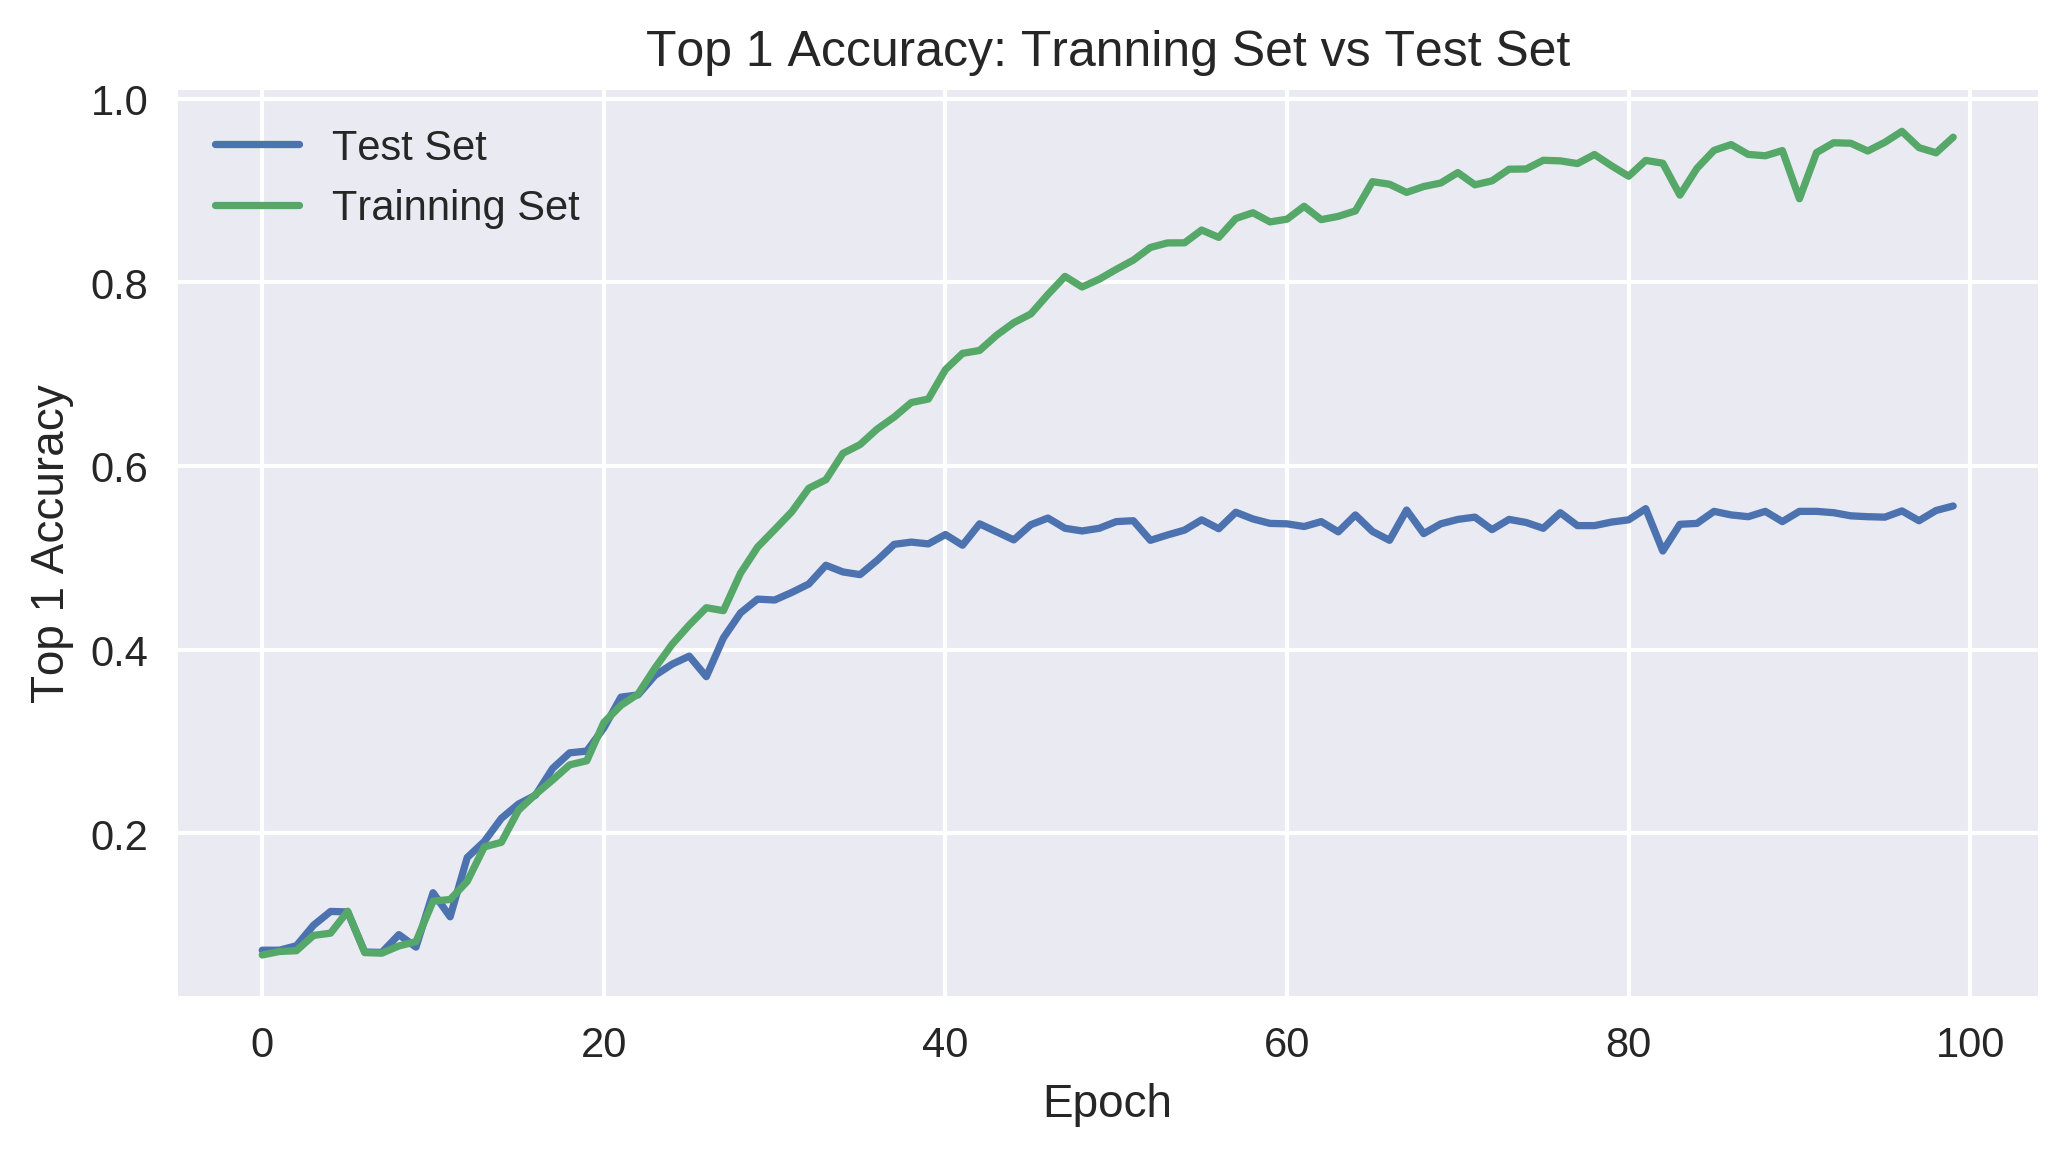

In [23]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()

### Plot Loss

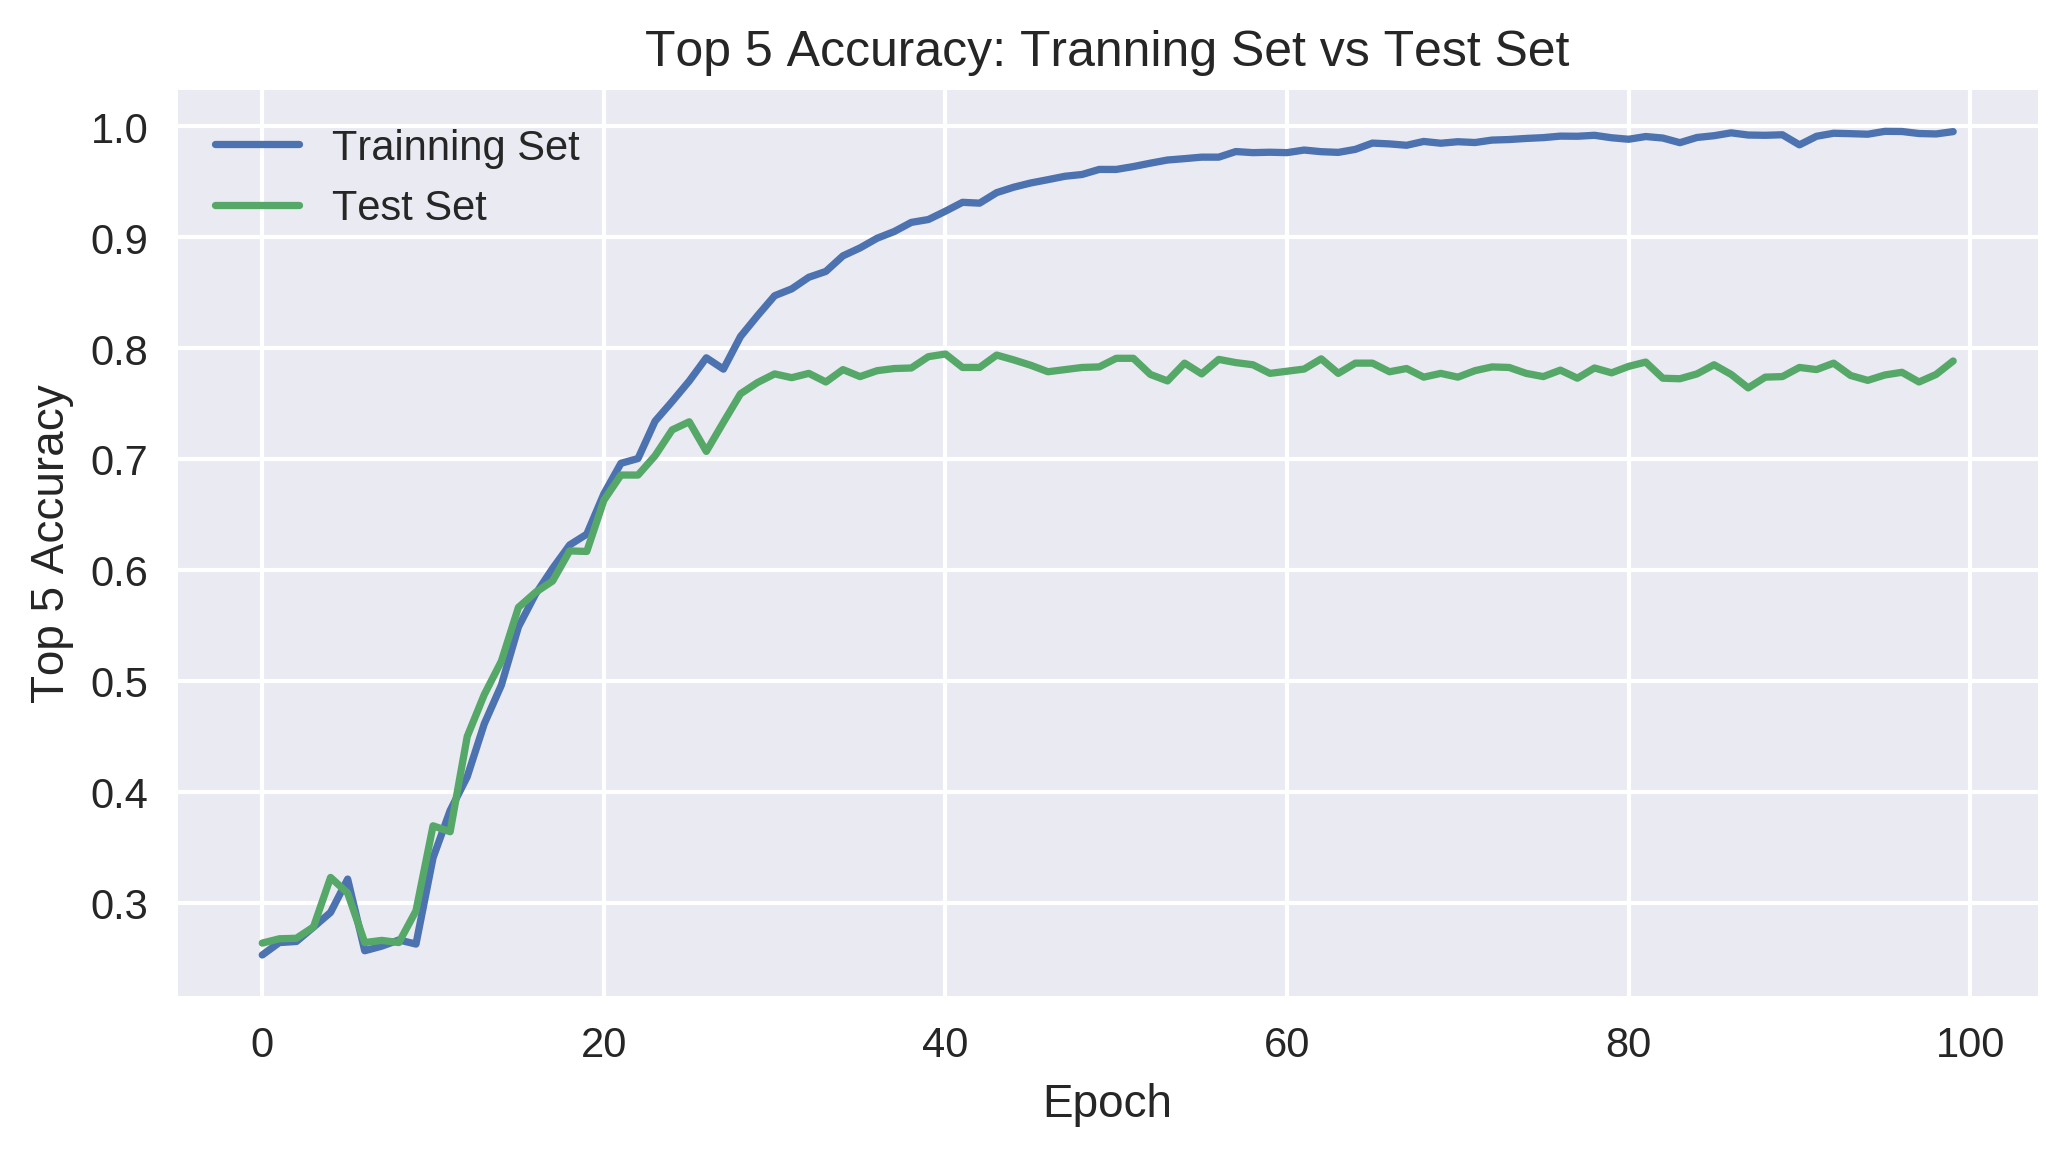

In [24]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()
plt.savefig('glove50-top5.pdf', format='pdf', dpi=300)

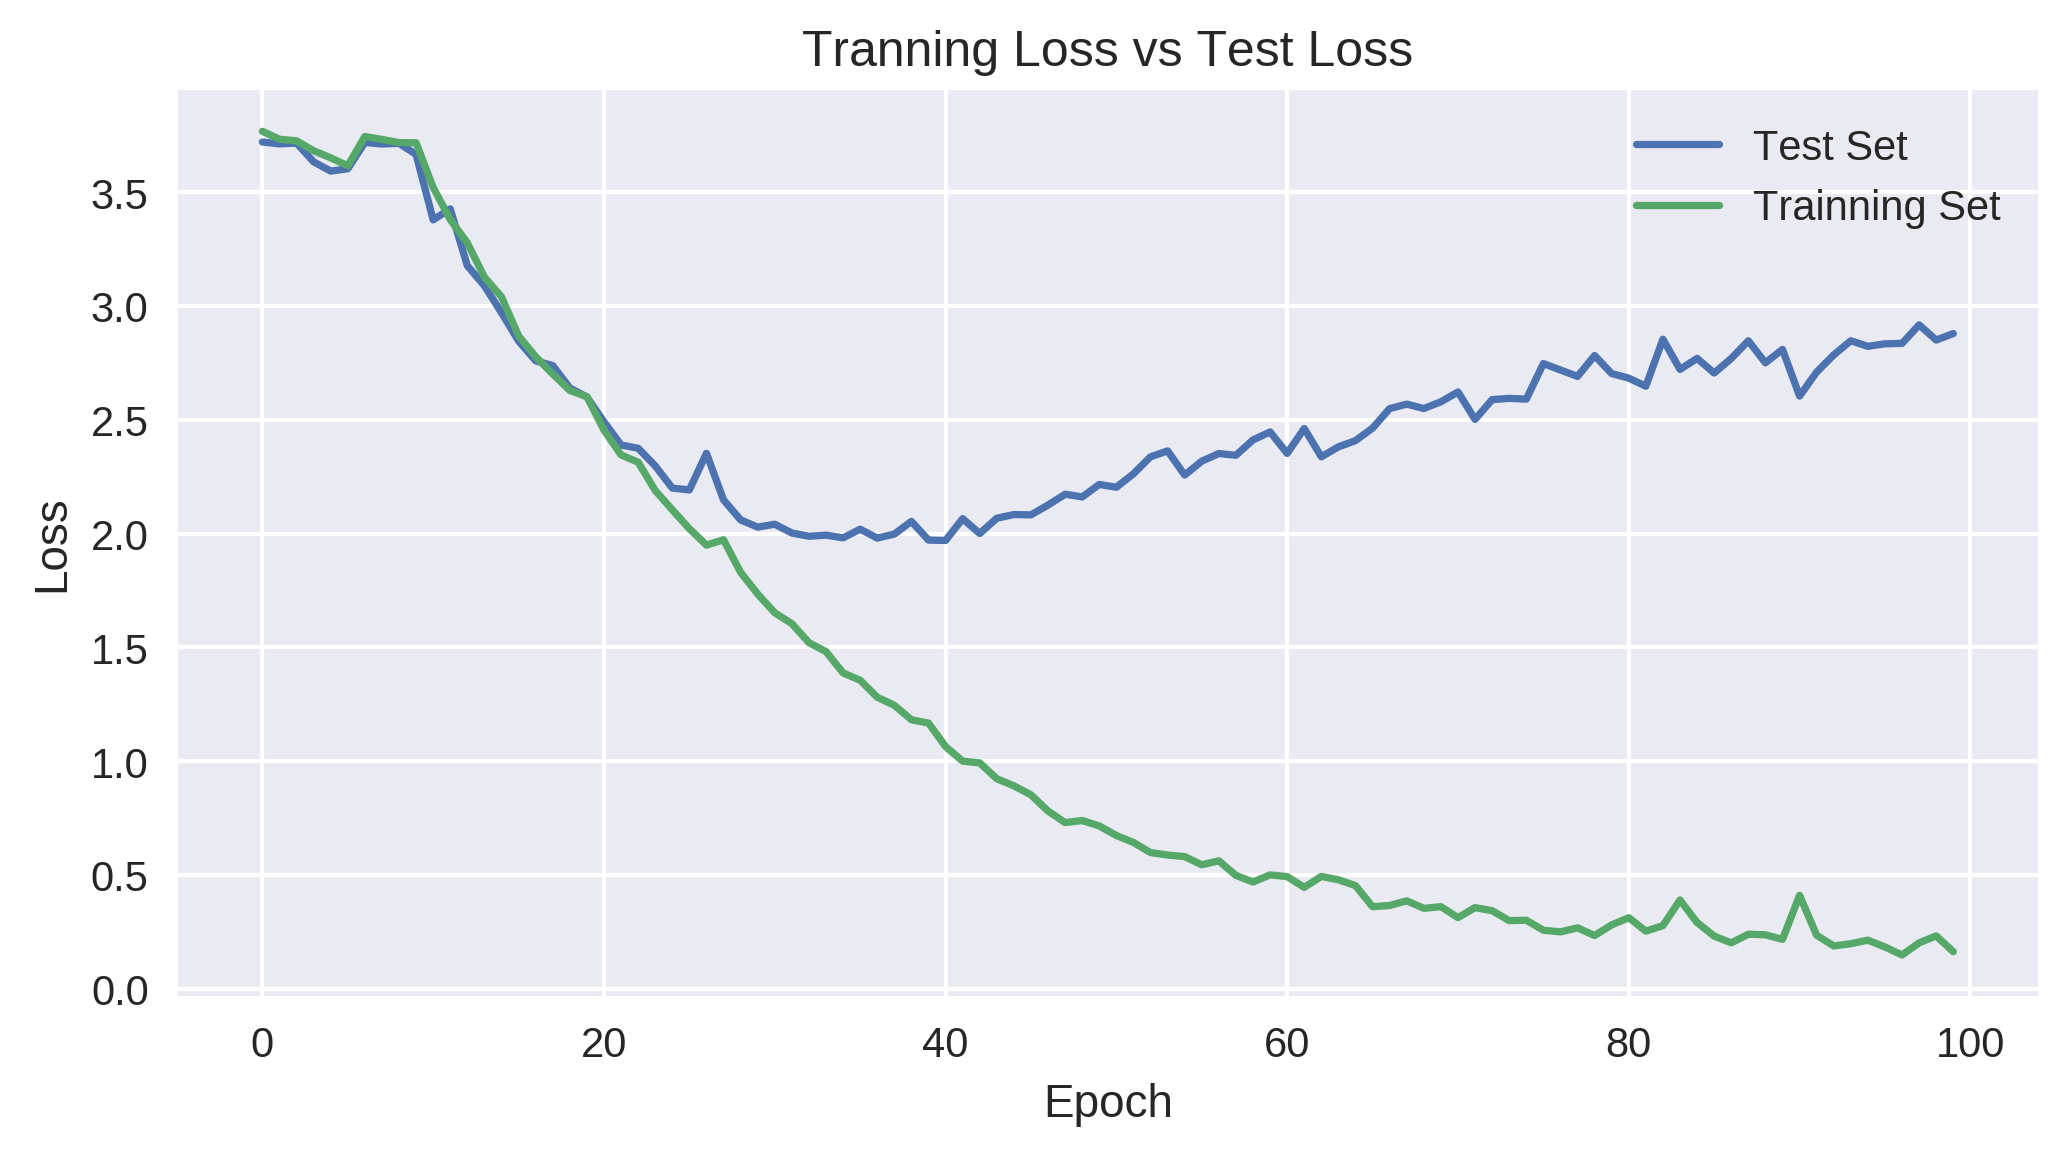

In [28]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig('glove50-loss.pdf', format='pdf', dpi=300)

### Save History

In [0]:
import pickle
  
f = open('ServeNet/trainHistoryDictGlove200', 'wb')
pickle.dump(history.history, f)
f.close()
  

### Load History

In [0]:
f = open('ServeNet/trainHistoryDictGlove200', 'rb')
his = pickle.load(f)
f.close()

In [45]:
his['loss']

[3.767600749258952,
 3.733149998677888,
 3.7257985259223627,
 3.682488910056798,
 3.651196191276542,
 3.616414654538151,
 3.7449545763432064,
 3.7320116155035725,
 3.7182544515180744,
 3.7171297088920316,
 3.5210687253593473,
 3.3801643792065175,
 3.2774315446259337,
 3.126967824827666,
 3.0403690186976857,
 2.869078676439074,
 2.7775281432460686,
 2.701385438699052,
 2.6291777863667454,
 2.6018259327472997,
 2.4551343957177085,
 2.3458986965641078,
 2.3139955869496465,
 2.189480297820521,
 2.1049058503680786,
 2.021630187655675,
 1.949644466948072,
 1.9730902939290083,
 1.8299954041726745,
 1.7346988409357706,
 1.6520624042188359,
 1.6046870642954032,
 1.5211582220966968,
 1.4816412273539883,
 1.388102275198439,
 1.3558443319352846,
 1.2812277690157667,
 1.2457361149109893,
 1.1823074589012792,
 1.1677057005333868,
 1.0645893323851472,
 1.0003835790104192,
 0.9926794305394234,
 0.9230598775855898,
 0.8919164923689392,
 0.8525828815850809,
 0.781041545548287,
 0.7305474288428665,
 0.73

### Model Save

In [0]:
model.save('ServeNet/Serve_Net_Glove200.h5') 

### Model Load

In [0]:
model = load_model('ServeNet/Serve_Net_Glove50.h5')

In [47]:
print("Training set:")
loss_train, mae_train, top5error_train = model.evaluate(X_train, Y_train)
print("Training accuracy = ", top5error_train)
print('Test set:')
loss_test, mae_test, top5error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)

Training set:
8123/8123 [==============================] - 36s 4ms/step
Training accuracy =  0.9981533916040871
Test set:
2061/2061 [==============================] - 9s 4ms/step
Training accuracy =  0.7797185833566342


In [0]:
# This code allows you to see the mislabelled examples
C = 50
# y_test_oh = np.eye(C)[Y_test.reshape(-1)]
# X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
predY_test = model.predict(X_test)

In [68]:
print(predY_test.shape)
print(Y_test.shape)

(2061, 50)
(2061, 50)


In [49]:
print(np.argmax(predY_test[0]))
print(np.argmax(Y_test[0]))

35
21


In [133]:
# Heatmap Data
non_onehot_pred_test = np.argmax(predY_test, axis=1)
non_onehot_Y_test = np.argmax(Y_test, axis=1)
categories = ['Financial', 'Project Management', 'Banking', 'Backend', 'Shipping', 'File Sharing', 'Email', 'Mapping', 'Domains', 'Social', 'Weather', 'Storage', 'Tools', 'Games', 'Events', 'Security', 'Analytics', 'Travel', 'Data', 'Reference', 'Office', 'Medical', 'Photos', 'Images', 'Education', 'Cloud', 'Chat', 'Application Development', 'Database', 'Messaging', 'News Services', 'Advertising', 'eCommerce', 'Transportation', 'Government', 'Other', 'Music', 'Sports', 'Internet of Things', 'Science', 'Telephony', 'Stocks', 'Media', 'Entertainment', 'Payments', 'Real Estate', 'Bitcoin', 'Search', 'Enterprise', 'Video', 'All']

print(non_onehot_pred_test.shape)
print(non_onehot_Y_test.shape)


(2061,)
(2061,)


In [0]:
# Heat Map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True)  

In [135]:
cross.head()

Predicted,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,All
Actual,,,,,,,,,,,,,,,,,,,,,
0,7,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,1,0,0,16
1,0,24,0,0,0,4,0,0,0,2,...,2,0,0,0,0,0,1,0,0,41
2,0,1,30,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,39
3,0,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,16
4,0,0,1,0,14,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,28


In [136]:
cross.index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    16,    17,    18,    19,
          20,    21,    22,    23,    24,    25,    26,    27,    28,    29,
          30,    31,    32,    33,    34,    35,    36,    37,    38,    39,
          40,    41,    42,    43,    44,    45,    46,    47,    48,    49,
       'All'],
      dtype='object', name='Actual')

In [137]:
cross.columns

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    16,    17,    18,    19,
          20,    21,    22,    23,    24,    25,    26,    27,    28,    29,
          30,    31,    32,    33,    34,    35,    36,    37,    38,    39,
          40,    41,    42,    43,    44,    45,    46,    47,    48,    49,
       'All'],
      dtype='object', name='Predicted')

In [147]:
cross.index = categories
cross.index.name = "Actual"
cross.columns = categories
cross.columns.name = "Predicted"
cross.head()

Predicted,Financial,Project Management,Banking,Backend,Shipping,File Sharing,Email,Mapping,Domains,Social,...,Stocks,Media,Entertainment,Payments,Real Estate,Bitcoin,Search,Enterprise,Video,All
Actual,,,,,,,,,,,,,,,,,,,,,
Financial,7,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,1,0,0,16
Project Management,0,24,0,0,0,4,0,0,0,2,...,2,0,0,0,0,0,1,0,0,41
Banking,0,1,30,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,39
Backend,0,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,16
Shipping,0,0,1,0,14,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,28


In [114]:
sns.load_dataset("flights").head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


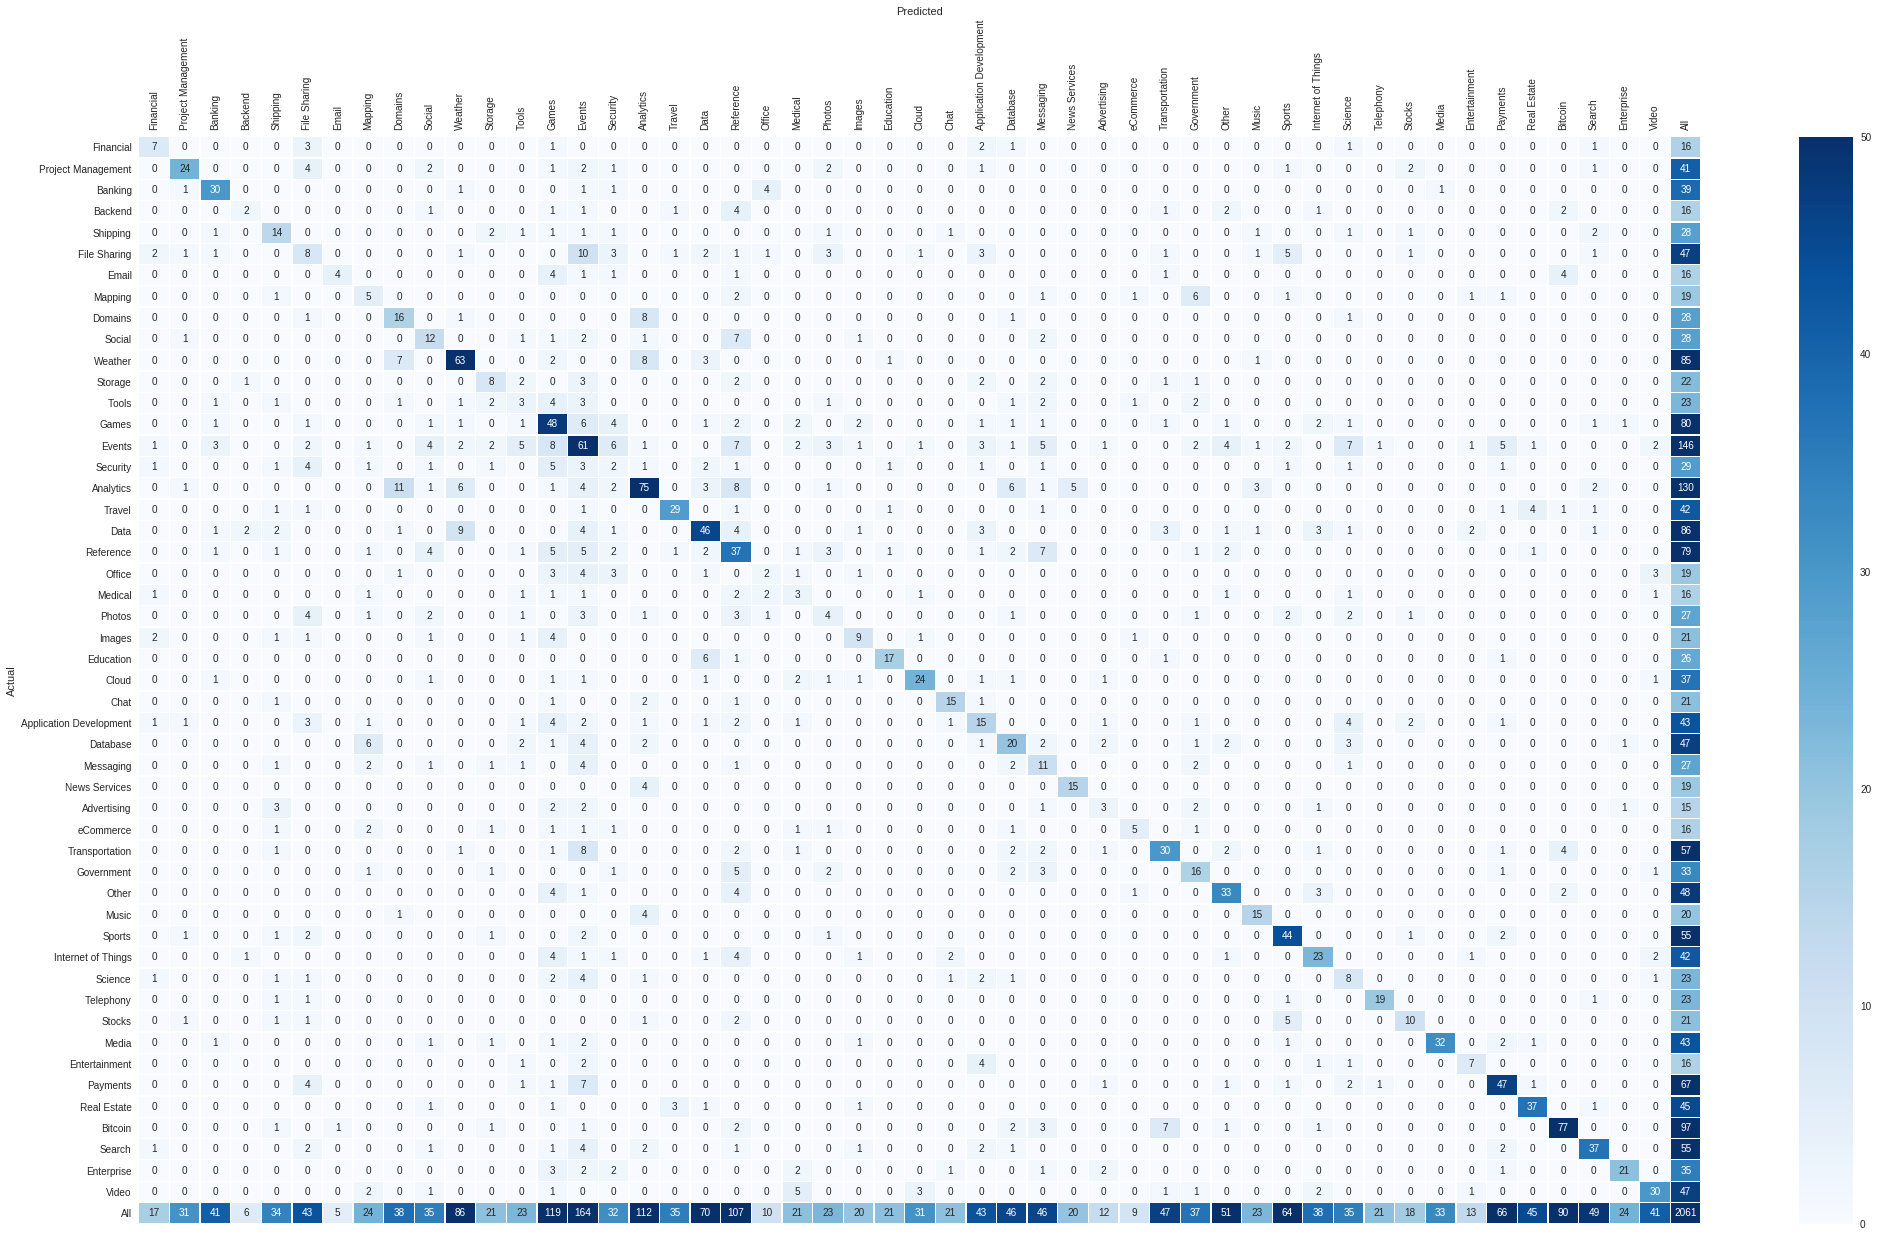

In [150]:
f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

plt.savefig('ServeNet/heatmap.pdf', format='pdf', dpi=300)